In [1]:
import numpy as np
from anytree import Node, RenderTree
import networkx as nx
import matplotlib.pyplot as plt
import random
import io, sys, os
import pandas as pd
from IPython.display import display
from collections import defaultdict
import cvxpy as cvx
from scipy import linalg
from sklearn.cluster import KMeans

ModuleNotFoundError: No module named 'cvxpy'

In [3]:
def goemans_williamson_max_cut(W):
    """
    Implements the Goemans-Williamson algorithm for max-cut approximation with vectorized operations
    
    Parameters:
    W (numpy.ndarray): Symmetric weight matrix where W[i,j] is the weight of edge (i,j)
    
    Returns:
    list: Binary partition of vertices (1 or -1 for each vertex)
    float: Value of the cut
    """
    n = W.shape[0]
    
    # Step 1: Solve the SDP relaxation using CVXPY
    X = cvx.Variable((n, n), symmetric=True)
    
    # Vectorized constraints: X is PSD and diagonal elements are 1
    constraints = [
        X >> 0,  # X is positive semidefinite
        cvx.diag(X) == np.ones(n)  # All diagonal elements equal to 1 (vectorized)
    ]
    
    # Vectorized objective function
    objective = 0.25 * cvx.sum(cvx.multiply(W, (1 - X)))
    prob = cvx.Problem(cvx.Maximize(objective), constraints)
    
    # Solve the SDP
    prob.solve()
    
    if prob.status != cvx.OPTIMAL:
        raise ValueError("SDP relaxation failed to solve optimally")
    
    X_opt = X.value
    
    # Step 2: Get the vector representation using eigendecomposition instead of Cholesky
    eigvals, eigvecs = linalg.eigh(X_opt)
    
    # Filter out negative or very small eigenvalues (numerical issues)
    tol = 1e-8
    pos_indices = eigvals > tol
    eigvals_filtered = eigvals[pos_indices]
    eigvecs_filtered = eigvecs[:, pos_indices]
    
    # Construct the vectors: V = U * sqrt(D)
    vectors = eigvecs_filtered @ np.diag(np.sqrt(eigvals_filtered))
    
    # Step 3: Random hyperplane rounding
    # Generate a random unit vector
    r = np.random.randn(vectors.shape[1])
    r = r / np.linalg.norm(r)
    
    # Vectorized dot product and sign operation
    signs = np.sign(vectors @ r)
    
    # Handle possible zeros in signs (unlikely but possible)
    if np.any(signs == 0):
        signs[signs == 0] = np.random.choice([-1, 1], size=np.sum(signs == 0))
    
    # Step 4: Calculate the cut value (using vectorized operations)
    # Create a matrix where entry is 1 if vertices are in different partitions
    different_partitions = (signs.reshape(-1, 1) != signs).astype(int)
    
    # Use only upper triangular part (to count each edge once)
    upper_tri_mask = np.triu(np.ones((n, n)), k=1).astype(bool)
    
    # Multiply by the weight matrix and sum
    cut_value = np.sum(W[upper_tri_mask] * different_partitions[upper_tri_mask])
    
    return signs.tolist(), cut_value

def max_k_cut(W, k):
    """
    Implements a generalized Goemans-Williamson algorithm for max-k-cut approximation with vectorized operations
    
    Parameters:
    W (numpy.ndarray): Symmetric weight matrix where W[i,j] is the weight of edge (i,j)
    k (int): Number of partitions
    
    Returns:
    list: Partition assignment for each vertex (values 0 to k-1)
    float: Value of the cut
    """
    n = W.shape[0]
    
    # Step 1: Solve the SDP relaxation using CVXPY
    X = cvx.Variable((n, n), symmetric=True)
    
    # Vectorized constraints
    constraints = [
        X >> 0,  # X is positive semidefinite
        cvx.diag(X) == np.ones(n)  # All diagonal elements equal to 1 (vectorized)
    ]
    
    # For k>2, the correct SDP relaxation (Frieze and Jerrum, 1997)
    objective = cvx.sum(cvx.multiply(W, (1 - X/(k-1))))
    prob = cvx.Problem(cvx.Maximize(objective), constraints)
    
    # Solve the SDP
    prob.solve()
    
    if prob.status != cvx.OPTIMAL:
        raise ValueError("SDP relaxation failed to solve optimally")
    
    X_opt = X.value
    
    # Step 2: Get the vector representation using eigendecomposition
    eigvals, eigvecs = linalg.eigh(X_opt)
    
    # Filter out negative or very small eigenvalues (numerical issues)
    tol = 1e-8
    pos_indices = eigvals > tol
    eigvals_filtered = eigvals[pos_indices]
    eigvecs_filtered = eigvecs[:, pos_indices]
    
    # Construct the vectors: V = U * sqrt(D)
    vectors = eigvecs_filtered @ np.diag(np.sqrt(eigvals_filtered))
    
    # Step 3: Use k-means clustering for k>2 (more effective than random projections)
    # Initialize with k-means++ for better starting positions
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    partition = kmeans.fit_predict(vectors)
    
    # Step 4: Calculate the cut value (vectorized)
    # Create a matrix where entry is 1 if vertices are in different partitions
    different_partitions = (partition.reshape(-1, 1) != partition).astype(int)
    
    # Use only upper triangular part (to count each edge once)
    upper_tri_mask = np.triu(np.ones((n, n)), k=1).astype(bool)
    
    # Multiply by the weight matrix and sum
    cut_value = np.sum(W[upper_tri_mask] * different_partitions[upper_tri_mask])
    
    return [partition.tolist(), cut_value]

# Example usage
if __name__ == "__main__":
    # Example symmetric matrix
    W = np.array([
        [0, 2, 3, 0, 1],
        [2, 0, 1, 4, 2],
        [3, 1, 0, 2, 0],
        [0, 4, 2, 0, 3],
        [1, 2, 0, 3, 0]
    ])
    
    # For k=2 (original max-cut)
    partition, cut_value = goemans_williamson_max_cut(W)
    print(f"Max-Cut (k=2) Partition: {partition}")
    print(f"Max-Cut (k=2) Cut value: {cut_value}")
    
    # For k=3
    k = 3
    partition, cut_value = max_k_cut(W, k)
    print(f"Max-{k}-Cut Partition: {partition}")
    print(f"Max-{k}-Cut Cut value: {cut_value}")

Max-Cut (k=2) Partition: [-1.0, 1.0, 1.0, -1.0, 1.0]
Max-Cut (k=2) Cut value: 15
Max-3-Cut Partition: [0, 1, 2, 0, 1]
Max-3-Cut Cut value: 16


In [4]:
def spectral_guess(A, k, eval = 0, evec = 0, max_iter=1000):
    n = A.shape[0]
    # Calculate degrees of vertices
    degrees = np.sum(A, axis=1)
    # Create the degree matrix
    D = np.diag(degrees)
    # Calculate the Laplacian matrix
    L = D - A
    # Get the eigenvectors of the graph
    eigvals, eigvecs = np.linalg.eig(L)
    # Get the indices of the k largest eigenvectors
    idx = np.argpartition(eigvals, 1-k)[1-k:]
    # Get the eigenvectors corresponding to the k-1 largest eigenvalues
    X = eigvecs[:, idx]
    
    if eval == 1:
        print("Eigenvalues: ", eigvals[idx])
    if evec == 1:
        print("Eigenvectors: ", X)

    # Initialize the centroids to the first k rows of X
    centroids = X[:k]
    # Initialize the cluster assignments to -1
    clusters = np.full(n, -1)
    for _ in range(max_iter):
        # Assign each node to the nearest centroid
        for i in range(n):
            clusters[i] = np.argmin(np.linalg.norm(centroids - X[i], axis=1))
        # Update the centroids
        new_centroids = np.array([np.mean(X[clusters == i], axis=0) for i in range(k)])
        # If the centroids haven't changed, return the clusters
        if np.array_equal(centroids, new_centroids):
            continue
        centroids = new_centroids
    
    z = clusters.tolist()

    result = 0
    for i in range(n):
        for j in range(i+1,n):
            if z[i] != z[j]:
                result += A[i][j]
    return [z, float(result)]

In [5]:
class GreedyFourierSearch:
    def __init__(self, A, k):
        # Validate inputs
        if not isinstance(k, int) or not isinstance(A, np.ndarray):
            raise ValueError("k must be an integer and A must be a numpy array")
        
        n = A.shape[0]
        if k > n:
            raise ValueError("k must be less than n")
        
        if A.shape[0] != A.shape[1]:
            raise ValueError("A must be a square matrix")
        
        if not np.all(A >= 0):
            raise ValueError("A must contain only non-negative values")
        
        if not np.allclose(A, A.T):
            raise ValueError("A must be symmetric")        
        
        # Calculate degrees of vertices
        degrees = np.sum(A, axis=1)
        
        # Get the sorted indices based on degrees
        sorted_indices = np.argsort(degrees)
        
        # Reorder the matrix A based on sorted indices
        A = A[sorted_indices, :][:, sorted_indices]
        
        self.A = A #Reordered matrix greatly improves performance.
        self.k = k
        self.n = n
        self.root = Node(("root", []), bound=float('inf'))

    def get_address(self, node):
        if node.is_root:
            return []
        return [node.name[0]] + node.parent.name[1] #Addresses are written in reverse to go from n down to 1.
    
    def value(self, node):
        # Check if the node is an nth child of the root
        if node.depth != self.n: #DEBUG LINE
            return print(str(node.name[1]) + " tried to be evaluated rather than bounded")
        
        # Use the address directly
        z = node.name[1]
        
        result = 0
        for i in range(self.n):
            for j in range(i+1,self.n):
                if z[i] != z[j]:
                    result += self.A[i][j]
        
        return result
    
    def _bound(self, node):
        """
        Computes the upper bound for a given node.
        For now, it returns +infinity as a dummy upper bound.

        :param node: The node for which to compute the upper bound.
        :return: The computed upper bound.
        """
        
        address = node.name[1]
        l = len(address)

        if l <= 1: #To stop unnecessary computation at the start.
            return [float('inf')]
        
        if l >= self.n: #DEBUG LINE
            print("Address at " + str(address) + " is " + str(l) + " long")
            return [float('inf')]

        
        #Term 0 (|m_0|= 0)
        Al = self.A[:self.n-l, :self.n-l] #Accounting for 0-indexing
        b0x = self.k*0.5*np.sum(self.A)

        # Convert address to a NumPy array
        address_array = np.array(address)
        # Create the Del matrix using broadcasting
        Del = (address_array[:, None] == address_array[None, :]).astype(int)
        b0y = (-1)*0.5*self.k*np.sum(np.multiply(Del,self.A[self.n-l:,self.n-l:,]))
        
        b0z = (-1)*0.5*np.sum(Al) #This looks like term 1 a lot, let's cancel out later.
        
        b0 = b0x+b0y+b0z
        """
        Actually pretty good - greedy search looks promising!
        Fourier sparsity => Smoothness => Low Variance => Greedy works well. 
        Need to make this more efficient. Can just store this 1 value at each layer and update it as we go down.
        """
        return [float(b0/self.k)]
    
    def _branch(self, node):
        #Only create one child for the root node, this is the beginnings of the overall branching simplification.
        if node == self.root:
            child = Node((0, [0]),parent=node)
            child.bound = float('inf')
            return

        if len(node.name[1]) >= self.n: #DEBUG LINE
            print(str(node.name[1]) + " tried to have children") 
            return #Is creating extra nodes beyond depth n, this is a temporary fix.
        
        if len(node.name[1]) == self.n-1:
            for i in range(self.k):
                child = Node((i, [i] + node.name[1]), parent=node)
                child.bound = self.value(child)
            return

        # Create k children nodes
        for i in range(self.k): 
            child = Node((i, [i] + node.name[1]), parent=node)
            child.bound = sum(self._bound(child))
            if node:
                if child.bound > node.bound:
                    child.bound = node.bound
        return
    
    def search(self, node): # Add updates parameter with default value False
        if len(node.name[1]) == self.n:
            return [float(node.bound), node.name[1]]

        self._branch(node)
        best_child = max(node.children, key=lambda child: child.bound)
        return self.search(best_child)
        



In [6]:
def randdataset(N, m, D, dataset=None, seed=None, weights = None, name = None): 

    if seed is not None:
            random.seed(seed)  # Set seed for reproducibility
            np.random.seed(seed)
            print("Seed set to " + str(seed))

    if dataset is None:  # Initialize the dataset dictionary
        dataset = {}
    
    if m == 0:  # Base case: when no more graphs need to be generated
        return [name, dataset]
    
    # Generate a random graph
    G = nx.gnp_random_graph(N[-1], D[-1])  
    if weights is not None:
        for (u, v) in G.edges():
            G[u][v]['weight'] = random.uniform(weights[0], weights[1])
    
    N = N[:-1]  # Remove the last element of N
    D = D[:-1]  # Remove the last element of D
    A = nx.to_numpy_array(G, dtype=float)  
    
    # Store it in the dataset
    dataset[m - 1] = (A, G)  # Using m-1 to maintain consistency with the original for-loop

    # Recursive call for the remaining m-1 graphs
    return randdataset(N, m - 1, D, dataset, name = name)


def test(data, k, showT = True, showG = True, name = None):
    A = data[0]
    G = data[1]

    if showG:
        num_vertices = G.number_of_nodes()
        num_edges = G.number_of_edges()

        # Calculate figure size based on the number of vertices and edges
        width = 8 + num_vertices * 0.1
        height = 6 + num_edges * 0.05

        fig, ax = plt.subplots(figsize=(width, height))
        nx.draw(G, ax=ax, with_labels=True, node_color='lightblue', edge_color='white', node_size=500, font_size=10, font_color='white')
        plt.title(name, color='white')  # Set the title color to white
        ax.set_facecolor('gray')  # Set the background color to black
        ax.axis('off')  # Turn off the axis
        fig.set_facecolor('gray')  # Set the figure background color to black
        plt.show()
        
        pass

    bb = GreedyFourierSearch(A, k)
    Optima = bb.search(bb.root)
    Max = float(round(Optima[0],2))
    Arg = Optima[1]

    count = 0
    for pre, fill, node in RenderTree(bb.root): #fill is just a filler variable because of how RenderTree works.
        count += 1
        if showT:
            if len(node.name[1]) < bb.n:
                bounds = bb._bound(node)  # Get the bounds [b1, b2, b3]
                print(f'{pre} {node.depth} {node.name[1]} {bounds}')
                #print(f'{pre} {node.depth} {node.name[1]} {float(round(node.bound,2))}')
            else: print(f'{pre} {node.depth} {node.name[1]} {float(round(bb.value(node),2))}')

    specguess = spectral_guess(A, k)

    result = [Max,Arg,specguess[1],specguess[0]]

    if showG:
        present(result, eff = True, max = True)
    
    return result

def multitest(dataset, K, showG = True, showT = False, i=0, results=None):  
    if results is None:  
        results = [[], [], [], []]  # Initialize the results list

    if i >= len(K):  # Correctly compare integer i to length of K
        return results
    
    # Call test and store its result
    result = test(dataset[1][i], K[i], showG = showG, showT = showT, name = dataset[0])
    testmax = result[0]
    testarg = result[1]
    testspec1 = result[2]
    testspec0 = result[3]

    # Append the result (percentage pruned) to results
    results[0].append(testmax)
    results[1].append(testarg)
    results[2].append(testspec1)
    results[3].append(testspec0)
    
    # Continue recursion
    return multitest(dataset, K, showG, showT, i+1, results)  # Pass the results list down the recursion

def present(result, eff = True, max = False):
    if eff:
        print("The spectral guess for the graph is: " + str(result[2]) + " at " + str(result[3]))
    if max:
        print("The greedy guess for the graph is: " + str(result[0]) + " at " + str(result[1]))
    return

def multipresent(results, eff = True, max = False, ):
    if eff:
        print("The spectral guess for the graph is: " + str(results[2]) + " at " + str(results[3]))
    if max:
        print("The greedy guess for the graph is: " + str(results[0]) + " at " + str(results[1]))
    return

In [7]:
def statistics(results):
    greedy = np.array(results[0])
    spectral = np.array(results[2])
    mean = float(round(np.mean(greedy-spectral), 2))
    median = float(round(np.median(greedy-spectral), 2))
    std = float(round(np.std(greedy-spectral), 2))
    return [mean, median, std]

In [ ]:
#Parameters for Dataset Construction
#Size of each dataset (number of graphs)
m=50

# Number of vertices for graphs in a certain range
v = 100
V = 100
N = [random.randint(v,V) for i in range(m)]
print(N)

# Weight range for the weighted graphs
w = 0.1
W = 1

# Special Parameters
eps = 0.05 #Should be between 0.01 and 0.1.

[15, 19, 15, 15, 19, 17, 16, 15, 16, 17, 15, 17, 20, 17, 20, 19, 15, 17, 20, 20, 18, 16, 17, 17, 19, 19, 19, 15, 18, 18, 19, 17, 16, 16, 16, 20, 16, 16, 19, 20, 18, 17, 17, 20, 17, 16, 17, 20, 15, 18]


In [10]:
# Unweighted Datasets
UnweightedDatasets = {}
UnweightedDatasets['Isolated'] = randdataset(N, m, [1/i for i in N], name='Isolated')
UnweightedDatasets['Transitioning to Connectivity'] = randdataset(N, m, [float(np.log2(i)/i) for i in N], name='Transitioning to Connectivity')
UnweightedDatasets['Extremely Sparse'] = randdataset(N, m, [float(1/np.sqrt(i)) for i in N], name='Extremely Sparse')
UnweightedDatasets['Very Sparse'] = randdataset(N, m, [0.1 for i in N], name='Very Sparse')
UnweightedDatasets['Moderately Sparse'] = randdataset(N, m, [0.25 for i in N], name='Moderately Sparse')
UnweightedDatasets['Moderately Dense'] = randdataset(N, m, [0.5 for i in N], name='Moderately Dense')
UnweightedDatasets['Very Dense'] = randdataset(N, m, [0.75 for i in N], name='Very Dense')
#UnweightedDatasets['Extremely Dense'] = randdataset(N, m, [1-eps for i in N], name='Extremely Dense')
#UnweightedDatasets['Complete'] = randdataset(N, m, [1 for i in N], name='Complete')

# Weighted Datasets
WeightedDatasets = {}
WeightedDatasets['Isolated'] = randdataset(N, m, [1/i for i in N], weights=(w, W), name='Isolated')
WeightedDatasets['Transitioning to Connectivity'] = randdataset(N, m, [float(np.log2(i)/i) for i in N], weights=(w, W), name='Transitioning to Connectivity')
WeightedDatasets['Extremely Sparse'] = randdataset(N, m, [float(1/np.sqrt(i)) for i in N], weights=(w, W), name='Extremely Sparse')
WeightedDatasets['Very Sparse'] = randdataset(N, m, [0.1 for i in N], weights=(w, W), name='Very Sparse')
WeightedDatasets['Moderately Sparse'] = randdataset(N, m, [0.25 for i in N], weights=(w, W), name='Moderately Sparse')
WeightedDatasets['Moderately Dense'] = randdataset(N, m, [0.5 for i in N], weights=(w, W), name='Moderately Dense')
WeightedDatasets['Very Dense'] = randdataset(N, m, [0.75 for i in N], weights=(w, W), name='Very Dense')
#WeightedDatasets['Extremely Dense'] = randdataset(N, m, [1-eps for i in N], weights=(w, W), name='Extremely Dense')
#WeightedDatasets['Complete'] = randdataset(N, m, [1 for i in N], weights=(w, W), name='Complete')

In [151]:
# Testing of the algorithm over various datasets for the two-cut problem
U2Cut = {}
for key in UnweightedDatasets.keys():
    U2Cut[key] = multitest(UnweightedDatasets[key], [2 for i in range(m)], showG = False)
    print("Dataset: " + key)

W2Cut = {}
for key in WeightedDatasets.keys():
    W2Cut[key] = multitest(WeightedDatasets[key], [2 for i in range(m)], showG = False)
    print("Dataset: " + key)


c:\Users\Soap Suds\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Soap Suds\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\_core\_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Dataset: Isolated
Dataset: Transitioning to Connectivity
Dataset: Extremely Sparse
Dataset: Very Sparse
Dataset: Moderately Sparse
Dataset: Moderately Dense
Dataset: Very Dense
Dataset: Isolated
Dataset: Transitioning to Connectivity
Dataset: Extremely Sparse
Dataset: Very Sparse
Dataset: Moderately Sparse
Dataset: Moderately Dense
Dataset: Very Dense


In [152]:
# Testing of the algorithm over various datasets for the three-cut problem
U3Cut = {}
for key in UnweightedDatasets.keys():
    U3Cut[key] = multitest(UnweightedDatasets[key], [3 for i in range(m)], showG = False)
    #U3Cut[key] = [None]
    print("Dataset: " + key)

W3Cut = {}
for key in WeightedDatasets.keys():
    W3Cut[key] = multitest(WeightedDatasets[key], [3 for i in range(m)], showG = False)
    #W3Cut[key] = [None]
    print("Dataset: " + key)

Dataset: Isolated
Dataset: Transitioning to Connectivity
Dataset: Extremely Sparse
Dataset: Very Sparse
Dataset: Moderately Sparse
Dataset: Moderately Dense
Dataset: Very Dense
Dataset: Isolated
Dataset: Transitioning to Connectivity
Dataset: Extremely Sparse
Dataset: Very Sparse
Dataset: Moderately Sparse
Dataset: Moderately Dense
Dataset: Very Dense


In [153]:
# Testing of the algorithm over various datasets for the four-cut problem
U4Cut = {}
for key in UnweightedDatasets.keys():
    U4Cut[key] = multitest(UnweightedDatasets[key], [4 for i in range(m)], showG = False)
    #U4Cut[key] = [None]
    print("Dataset: " + key)

W4Cut = {}
for key in WeightedDatasets.keys():
    W4Cut[key] = multitest(WeightedDatasets[key], [4 for i in range(m)], showG = False)
    #W4Cut[key] = [None]
    print("Dataset: " + key)

Dataset: Isolated
Dataset: Transitioning to Connectivity
Dataset: Extremely Sparse
Dataset: Very Sparse
Dataset: Moderately Sparse
Dataset: Moderately Dense
Dataset: Very Dense
Dataset: Isolated
Dataset: Transitioning to Connectivity
Dataset: Extremely Sparse
Dataset: Very Sparse
Dataset: Moderately Sparse
Dataset: Moderately Dense
Dataset: Very Dense


In [154]:
UCut = {2: U2Cut, 3: U3Cut, 4: U4Cut}
WCut = {2: W2Cut, 3: W3Cut, 4: W4Cut}

In [155]:
# Create a dictionary to hold the statis
UStats = {2: [], 3: [], 4: []}
WStats = {2: [], 3: [], 4: []}

# Populate the dictionary with the performance statistics
for key in UnweightedDatasets.keys():
    UStats[2].append(statistics(UCut[2][key]))
    UStats[3].append(statistics(UCut[3][key]))
    UStats[4].append(statistics(UCut[4][key]))
    WStats[2].append(statistics(WCut[2][key]))
    WStats[3].append(statistics(WCut[3][key]))
    WStats[4].append(statistics(WCut[4][key]))

In [156]:
# Unweighted datasets performance
U2Performance = pd.DataFrame(UStats[2], index=UnweightedDatasets.keys())
U2Performance.columns = ['Mean', 'Median', 'Standard Deviation']
U2Performance.name = "k = 2, Unweighted"

U3Performance = pd.DataFrame(UStats[3], index=UnweightedDatasets.keys())
U3Performance.columns = ['Mean', 'Median', 'Standard Deviation']
U3Performance.name = "k = 3, Unweighted"

U4Performance = pd.DataFrame(UStats[4], index=UnweightedDatasets.keys())
U4Performance.columns = ['Mean', 'Median', 'Standard Deviation']
U4Performance.name = "k = 4, Unweighted"

# Weighted datasets performance
W2Performance = pd.DataFrame(WStats[2], index=WeightedDatasets.keys())
W2Performance.columns = ['Mean', 'Median', 'Standard Deviation']
W2Performance.name = "k = 2, Weighted"

W3Performance = pd.DataFrame(WStats[3], index=WeightedDatasets.keys())
W3Performance.columns = ['Mean', 'Median', 'Standard Deviation']
W3Performance.name = "k = 3, Weighted"

W4Performance = pd.DataFrame(WStats[4], index=WeightedDatasets.keys())
W4Performance.columns = ['Mean', 'Median', 'Standard Deviation']
W4Performance.name = "k = 4, Weighted"


In [157]:
# Display DataFrames with their names
print(U2Performance.name)
display(U2Performance)

print(W2Performance.name)
display(W2Performance)

print(U3Performance.name)
display(U3Performance)

print(W3Performance.name)
display(W3Performance)

print(U4Performance.name)
display(U4Performance)

print(W4Performance.name)
display(W4Performance)

k = 2, Unweighted


,Mean,Median,Standard Deviation
Isolated,22.30,23.5,4.66
Transitioning to Connectivity,88.36,73.0,48.62
Extremely Sparse,56.34,58.0,74.45
Very Sparse,84.86,55.5,94.44
Moderately Sparse,85.30,-57.0,259.23
Moderately Dense,515.50,663.5,528.03
Very Dense,1341.56,1509.5,403.93


k = 2, Weighted


,Mean,Median,Standard Deviation
Isolated,23.60,24.0,5.28
Transitioning to Connectivity,83.37,76.5,56.83
Extremely Sparse,78.56,62.5,93.59
Very Sparse,87.46,66.0,82.93
Moderately Sparse,32.60,-60.5,230.18
Moderately Dense,447.83,280.5,527.28
Very Dense,1214.45,1511.5,504.18


k = 3, Unweighted


,Mean,Median,Standard Deviation
Isolated,26.54,26.0,6.56
Transitioning to Connectivity,95.10,99.5,48.53
Extremely Sparse,110.02,112.0,70.97
Very Sparse,147.94,148.0,93.52
Moderately Sparse,185.72,164.0,166.02
Moderately Dense,507.66,400.0,434.28
Very Dense,1204.40,1146.5,657.53


k = 3, Weighted


,Mean,Median,Standard Deviation
Isolated,28.15,26.0,8.14
Transitioning to Connectivity,86.21,94.0,43.12
Extremely Sparse,119.11,114.0,77.90
Very Sparse,125.65,129.0,68.51
Moderately Sparse,191.50,172.5,183.08
Moderately Dense,595.70,462.5,499.42
Very Dense,1336.33,1413.5,653.06


k = 4, Unweighted


,Mean,Median,Standard Deviation
Isolated,30.88,30.5,8.78
Transitioning to Connectivity,87.42,91.0,35.85
Extremely Sparse,114.38,123.5,58.92
Very Sparse,126.02,126.0,67.04
Moderately Sparse,281.90,247.5,195.79
Moderately Dense,497.34,447.0,350.38
Very Dense,965.50,872.5,585.11


k = 4, Weighted


,Mean,Median,Standard Deviation
Isolated,31.93,36.0,10.75
Transitioning to Connectivity,81.99,76.0,42.78
Extremely Sparse,116.10,126.5,63.30
Very Sparse,102.66,108.0,54.17
Moderately Sparse,288.33,230.5,209.66
Moderately Dense,573.31,436.0,360.53
Very Dense,1034.98,941.5,544.94


In [148]:
def matrix_column_sum_norm(matrix):
    """
    Sum the columns of a matrix to create a 1D vector, then compute its 2-norm.
    """
    matrix = np.array(matrix)
    column_sums = np.sum(matrix, axis=0)
    norm_2 = np.linalg.norm(column_sums, ord=2)
    return norm_2**2

def plot_exp_function(k, matrix, x_range=(-5, 5), num_points=1000):
    """
    Plot exp(-x^2 / (2 * norm_2(matrix)))
    
    Parameters:
    matrix (array-like): Input matrix
    x_range (tuple): Range of x values to plot (min, max)
    num_points (int): Number of points to plot
    """
    # Calculate the norm
    norm_2 = matrix_column_sum_norm(matrix)
    avg = (k-1)*np.sum(matrix)/(4*k)
    sig = np.linalg.norm(matrix)/(np.sqrt(2*k))
    
    # Create x values
    x = np.linspace(x_range[0], x_range[1], num_points)
    
    # Calculate y values: exp(-x^2 / (2 * norm_2))
    y = np.exp(1+((avg-x) / (np.e*sig)))
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, 'b-', linewidth=2, label=f'exp(-x²/(2×{norm_2:.2f}))')
    plt.xlabel('x')
    plt.ylabel('exp(-x²/(2×norm_2))')
    plt.title(f'Plot of exp(-x²/(2×norm_2)) where norm_2 = {norm_2:.2f}')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.xlim(x_range)
    plt.ylim(0, 1.1)
    
    # Show the plot
    plt.tight_layout()
    plt.show()
    
    return norm_2

In [116]:
X = randdataset([100], 1, [0.3], name = '10 Vertex Graph with 0.3 edge probability')

In [117]:
Results = multitest(X, [4], showG = 0, showT = 0)
multipresent(Results, eff = 1, max = 1)

The spectral guess for the graph is: [1086.0] at [[2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 3, 1, 2, 2, 0, 2, 2, 0, 1, 0, 2, 2, 0, 1, 1, 0, 0, 1, 0, 0, 2, 1, 1, 1, 1, 1, 1, 2, 0, 0, 2, 2, 1, 1, 1, 0, 1, 2, 2, 1, 2, 1, 2, 2, 2, 1, 1, 0, 1, 1, 1, 1, 0, 0, 2, 2, 2, 0, 0, 0, 2, 1, 1, 1, 1, 3, 2, 2, 2, 1, 0, 1, 1, 2, 1, 1, 0, 2, 1, 2, 2, 2, 1, 1, 0, 1]]
The greedy guess for the graph is: [1127.0] at [[2, 2, 2, 3, 3, 3, 2, 3, 1, 3, 3, 3, 3, 3, 3, 3, 2, 1, 3, 3, 2, 3, 3, 1, 2, 3, 1, 2, 3, 2, 3, 2, 2, 2, 2, 2, 1, 2, 2, 1, 0, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]]


In [144]:
k = 3
matrix = X[1][0][0]  # Extract the matrix from the dataset
avg = (k)*np.sum(matrix)/(4*(k+1))
sig = np.linalg.norm(matrix)/(np.sqrt(2*k))
print(avg)
print(sig)

565.125
22.41279396535232


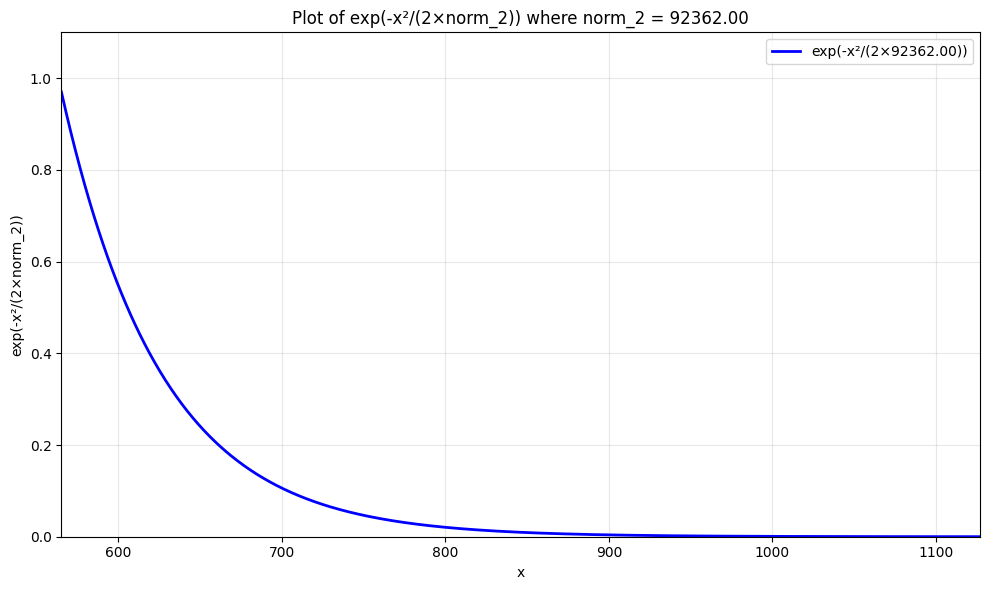

np.float64(92362.00000000001)

In [149]:
plot_exp_function(3, X[1][0][0], x_range=(avg, Results[0][0]), num_points=1000)
#plot_exp_function(3, X[1][0][0], x_range=(948, 1500), num_points=1000)